# TP 2: Réseau de neurones (2.2) : réseaux récurrents

Ce code récupère toutes les données et programmes annexes nécessaires au TP

In [1]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen


file_id = "12G-7vOB74a0C_V2iMRnJlrecHwk5tkfd"
resp = urlopen(f"https://drive.google.com/uc?export=download&id={file_id}")
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.extractall()

In [2]:
!ls

data_utils.py  img			 jazz.py  preprocess.py
grammar.py     jazz_improvisation.ipynb  output   qa.py


In [3]:
from IPython.display import clear_output, display
from ipywidgets import Output

In [4]:
!pip install livelossplot
clear_output()

In [5]:
from livelossplot import PlotLossesKerasTF
from tqdm.keras import TqdmCallback

ModuleNotFoundError: No module named 'keras'

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print("In Colab?", IN_COLAB)

In Colab? True


In [ ]:
if IN_COLAB:
    !pip install pretty_midi pyfluidsynth
    !apt-get install fluidsynth

    from IPython.display import Audio, display
    from pretty_midi import PrettyMIDI
    clear_output()

## 2. Improvisation Jazz avec des RNN

Dans cet exercice, nous allons entrainer un réseau récurrent à générer des notes de musique. Etant donné une mélodie jazz (une séquence de notes), il apprend à générer la note suivante sur la base de l'historique des notes.
Une fois entrainé, on peut générer une nouvelle séquence de notes à partir de rien.

Note: pour cet exercice nous aurons besoin d'installer le module `music21`. Il peut s'installer à partir de la cellule jupyter ci-dessous, ou directement avec pip ou anaconda.

In [ ]:
!pip install music21==6.7
#clear_output(wait=True)

##  Rappel sur les RNN (Recurrent neural networks):
Ce sont des modèles appropriés pour des information séquentielles.
Ils produisent une représentation à chaque étape d'une séquence qui prend en compte les éléments précédents dans la séquence, comme s'ils conservaient une "mémoire" des calculs précédents (d'où le nom pour un type particulier de RNN: Long Short-Term Memory).

Illustration pour un RNN "basique" :

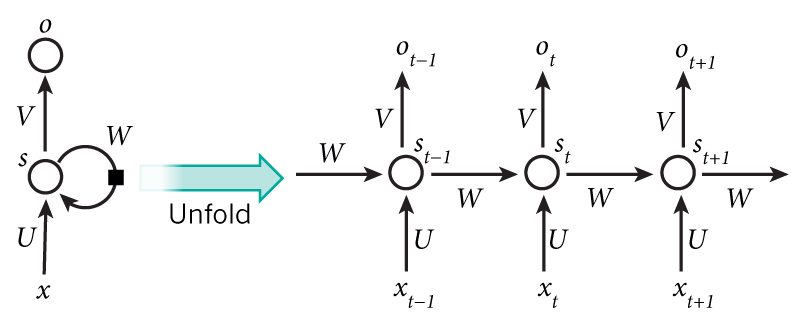


L'image de gauche présente le réseau avec la connection récurrente sur l'état caché $s$.

A droite on voit le même réseau, mais "déplié" dans le temps, état après état, pour trois états successifs. Pour la génération de musique cela veut dire : à chaque pas de temps la note courante de la séquence ($x_t$)
est entrée dans le réseau. Cette note est représentée par un vecteur one-hot. Par exemple, si on avait seulement
7 notes,  [𝑑𝑜,𝑟𝑒,𝑚𝑖,𝑓𝑎,𝑠𝑜𝑙,𝑙𝑎,𝑡𝑖] . Le vecteur de *mi* serait donc [0010000] , que des 0 sauf à la position de la note mi.  
Le réseau combine la note avec la représentation de l'historique (les notes précédentes), $s_{t-1}$ pour construire une nouvelle représentation
$s_t$. Ce nouvel état est passé au pas de temps suivant, et ainsi de suite. A chaque pas le réseau a aussi une sortie $o_t$. Dans notre cas, seule la dernière sortie nous intéresse et servira de prédiction de la note suivant la séquence.


Les architectures récurrentes plus élaborées (LSTM, GRU) font des calculs un peu plus complexes avec différents états intermédiaires, mais l'idée est la même.



Nous allons maintenant voir comment implémenter un tel modèle avec Keras.

In [ ]:
from music21 import *
import numpy as np
from data_utils import *
import matplotlib.pyplot as plt

In [ ]:
data_fn = 'original_metheny.mid'

D'abord nous chargeons les fichiers de données, le travail est fait par la fonction load_music qui est fournie avec le TP.

$X$ and $y$ représentent les données d'entrainement, les autres données serviront pour générer la musique finale à partir des prédictions du modèle.



In [ ]:
(X, y, n_values, chords,
 abstract_grammars, corpus, tones,
 tones_indices, indices_tones) = load_music_data()

ConverterException: File not found or no such format found for: data/original_metheny.mid

In [ ]:
n_train = X.shape[0]
n_timesteps = X.shape[1]

print('number of training examples:', n_train)
print('Tx (length of sequence):', n_timesteps)
print('total # of unique values:', n_values)

number of training examples: 85
Tx (length of sequence): 20
total # of unique values: 90


Nos données consistent en 85 exemples d'entrainement.
Chaque exemple de $X$ est représenté par une matrice 20x90 (20 notes par un vecteur one-hot de 90 valeurs).




In [ ]:
print('shape of X:', X.shape)

shape of X: (85, 20, 90)


\Chaque étiquette de $y$ est un vecteur one-hot de 90 valeurs, qui représente la note censée suivre les 20 premières stockées dans $X$.
Le but du réseau est de prédire la note correcte étant donnée ces 20 premières notes. (Donc un problème de classification).

In [ ]:
print('Shape of Y:', y.shape)

Shape of Y: (85, 90)


On prédira la note correct avec un LSTM, qui traitera la série de 20 notes pour produire une représentation à chaque étape de la séquence, et c'est la dernière sortie qui servira à prédire la note suivante. On fait passer cette dernière représentation dans une couche dense avec softmax, de dimension le nombre de notes possibles, pour obtenir une distribution de probabilités sur les 78 notes possibles.



In [ ]:
model = keras.Sequential([
    # Si vous voulez empiler des RNN, il faut passer return_sequences=True aux couches inférieures
    # pour qu'elles renvoient leurs sorties en séquences, et pas seulement l'état final
    # par ex:
    # keras.layers.LSTM(32, input_shape=(n_timesteps, n_values), return_sequences=True),
    keras.layers.LSTM(32, input_shape=(n_timesteps, n_values)),
    keras.layers.Dense(n_values, activation = 'softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32)                  │          15,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 90)                  │           2,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,714 (73.10 KB)

 Trainable params: 18,714 (73.10 KB)

 Non-trainable params: 0 (0.00 B)

Comme d'habitude il faut compiler le modèle :

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop')

Et lancer l'apprentissage. On visualise aussi la loss en même temps.

In [ ]:
PLOT_CONTEXT = Output()
display(PLOT_CONTEXT)

from livelossplot.inputs.tf_keras import PlotLossesCallback
from typing import Dict
class PLK(PlotLossesCallback):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def on_epoch_end(self, epoch: int, logs: Dict[str, float]):
        with PLOT_CONTEXT:
            super().on_epoch_end(epoch, logs)

Output()

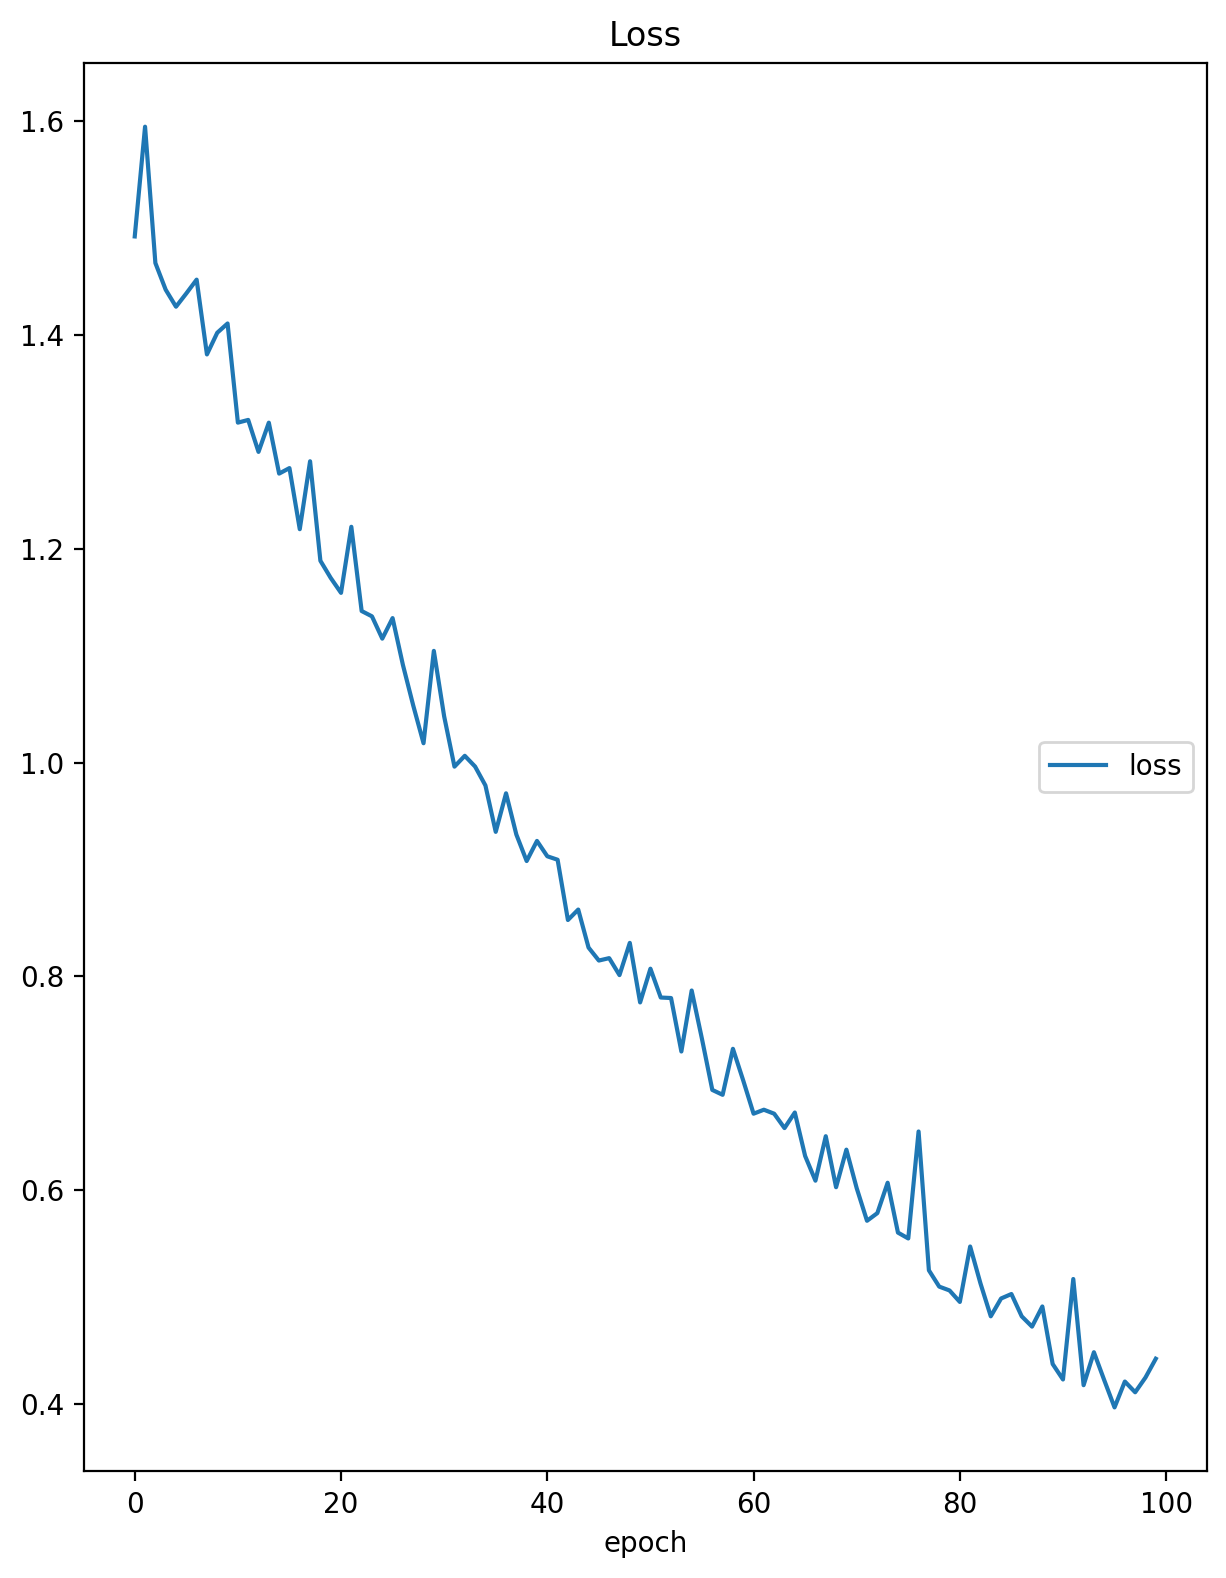

Loss
	loss             	 (min:    0.397, max:    1.595, cur:    0.442)


In [ ]:
history = model.fit(X, y, batch_size=10, epochs=100, verbose=0, callbacks=[PLK(), TqdmCallback()])

Une fois le modèle entrainé on peut l'utiliser pour générer des séquences de notes. Elles sont utilisées ci-dessous pour générer des improvisations jazz.
La fonction applique un certain nombre de post-traitements qui vont au-delà de ce TP, vous n'avez pas à vous en occuper.



In [ ]:
out_stream = generate_music(model, chords, abstract_grammars,
                            corpus, tones, tones_indices,
                            indices_tones, X)

Predicting new values for different set of chords.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/ste

Le code a generé un fichier midi dans le répertoire output.
On peut le jouer avec le code suivant, ou bien directement ouvrir le fichier créé avec un lecteur midi (ou convertir le midi en autre chose, comme du mp3).

In [ ]:
midi_file = 'output/my_music.midi'

if IN_COLAB:
    music = PrettyMIDI(midi_file=midi_file)
    waveform = music.fluidsynth()
    display(Audio(waveform, rate=44100))
else:
    mf = midi.MidiFile()
    mf.open(midi_file)
    mf.read()
    mf.close()
    s = midi.translate.midiFileToStream(mf)
    s.show('midi')

### Exercice

Essayez d'améliorer la génération: par exemple remplacez le LSTM par UN GRU. Modifier la taille de la représentation cachée. Essayez en empilant un autre LSTM sur le premier.

Observez la différence sur la courbe de loss. Est-ce que la musique créee est "meilleure" ?